In [1]:
%matplotlib inline

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import os
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import genpareto
from osgeo import gdal

In [2]:
def extract_max_rows(folder_path):
    if not os.path.exists(folder_path):
        print(f"Folder '{folder_path}' does not exist.")
        return

    # Create an empty DataFrame to store iceberg information
    result_df = pd.DataFrame(columns=['File_Name', 'Date', 'Max_Size_1', 'Max_Size_2'])

    csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv') and file[-5].isdigit()]

    # Iterate through each CSV file
    for file in csv_files:
        file_path = os.path.join(folder_path, file)
        
        df = pd.read_csv(file_path)
        if 'size_1' not in df.columns:
                print(f"Skipping file '{file}' - it does not contain a 'size_1' column.")
                continue
            
        columns_to_keep = ["date", "size_1", "size_2"]
        df = df[columns_to_keep]

        max_size_1_indices = df['size_1'].idxmax()
        max_size_2_indices = df['size_2'].idxmax()
        
        max_size_1_rows = df.loc[max_size_1_indices]
        max_size_2_rows = df.loc[max_size_2_indices]

        # append the iceberg information to df
        for i in range(len(max_size_1_rows)-1):
            result_df = result_df._append({'File_Name': file,
                                   'Date': max_size_1_rows.iloc[0],
                                    'Max_Size_1': max_size_1_rows.iloc[1],
                                    'Max_Size_2': max_size_1_rows.iloc[2]}, ignore_index=True)

    # Save the result DataFrame to a CSV file
    result_file_path = os.path.join(folder_path, 'max_rows_info.csv')
    result_df.to_csv(result_file_path, index=False)
    print(f"Results saved to: {result_file_path}")
    return result_df

In [89]:
result_df = extract_max_rows('BYU_consolidated_database/')

Skipping file 'uk132.csv' - it does not contain a 'size_1' column.
Skipping file 'uk213.csv' - it does not contain a 'size_1' column.
Skipping file 'uk06.csv' - it does not contain a 'size_1' column.
Skipping file 'uk60.csv' - it does not contain a 'size_1' column.
Skipping file 'e10.csv' - it does not contain a 'size_1' column.
Skipping file 'uk231.csv' - it does not contain a 'size_1' column.
Skipping file 'uk24.csv' - it does not contain a 'size_1' column.
Skipping file 'sa02.csv' - it does not contain a 'size_1' column.
Skipping file 'uk51.csv' - it does not contain a 'size_1' column.
Skipping file 'e01.csv' - it does not contain a 'size_1' column.
Skipping file 'uk222.csv' - it does not contain a 'size_1' column.
Skipping file 'uk15.csv' - it does not contain a 'size_1' column.
Skipping file 'uk321.csv' - it does not contain a 'size_1' column.
Skipping file 'uk240.csv' - it does not contain a 'size_1' column.
Skipping file 'uk33.csv' - it does not contain a 'size_1' column.
Skippi

In [90]:
result_df
#result_df.to_csv('icebergs_NICBYU.csv', index=False)

,File_Name,Date,Max_Size_1,Max_Size_2
0,d11.csv,1996336,48,9
1,d11.csv,1996336,48,9
2,c30.csv,2016001,9,3
3,c30.csv,2016001,9,3
4,b13.csv,1997054,16,5
...,...,...,...,...
377,d10.csv,1996063,17,9
378,a31.csv,1991090,20,9
379,a31.csv,1991090,20,9
380,b12.csv,1997054,13,3


In [104]:
result_df['Area'].median()

391.00905600000004

In [91]:
result_df.head()
result_df['Date'] = pd.to_datetime(result_df['Date'], format='%Y%j', errors='coerce')
result_df['Year'] = result_df['Date'].dt.year
result_df['Area'] = (result_df['Max_Size_1'] * 1.852) * (result_df['Max_Size_2'] * 1.852)

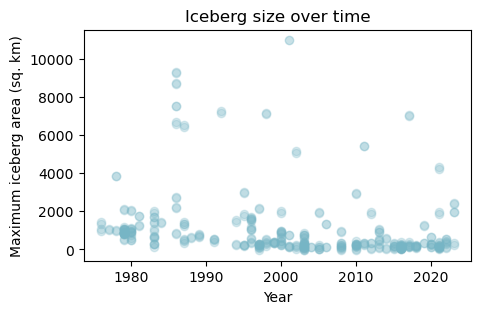

In [101]:
fig = plt.figure(figsize=(5,3))
plt.scatter(result_df.Year, result_df.Area+s, marker='o',alpha=0.26, color='#76b5c5')
plt.scatter(2001.0, 11000, marker='o',alpha=0.4, color='#76b5c5')

plt.xlabel('Year')
plt.ylabel('Maximum iceberg area (sq. km)')
plt.title('Iceberg size over time')
plt.show()

In [102]:
fig.savefig('year_vs_iceberg_size.jpg', dpi=300, bbox_inches = "tight")

In [106]:
icebergs = pd.read_csv('largest_annual_iceberg_NICBYU_manual_validation.csv')
area = icebergs.Area
year = icebergs.Year

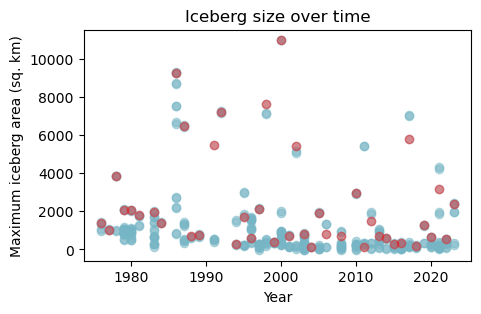

In [120]:
fig = plt.figure(figsize=(5,3))
plt.scatter(result_df.Year, result_df.Area+s, marker='o', color='#76b5c5', alpha=0.5)
plt.scatter(year, area, marker='o', color='#76b5c5', alpha=0.5)
plt.scatter(2000.0, 11000, marker='o', color='#76b5c5', alpha=0.5)
plt.scatter(year, area, marker='o',alpha=0.36, color='r')



plt.xlabel('Year')
plt.ylabel('Maximum iceberg area (sq. km)')
plt.title('Iceberg size over time')
plt.show()

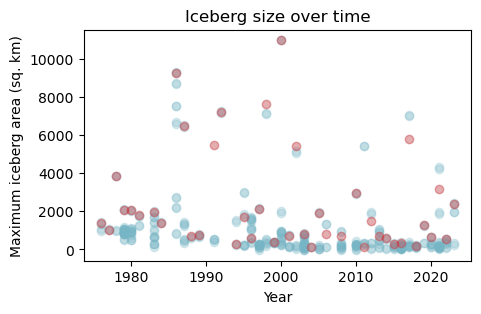

In [123]:
fig = plt.figure(figsize=(5,3))
plt.scatter(result_df.Year, result_df.Area+s, marker='o',alpha=0.26, color='#76b5c5')
plt.scatter(year, area, marker='o',alpha=0.26, color='#76b5c5')

plt.scatter(2000.0, 11000, marker='o',alpha=0.4, color='#76b5c5')
plt.scatter(year, area, marker='o',alpha=0.26, color='r')

plt.xlabel('Year')
plt.ylabel('Maximum iceberg area (sq. km)')
plt.title('Iceberg size over time')

fig.savefig('year_vs_iceberg_size.svg', dpi=300, bbox_inches = "tight")
plt.show()

In [124]:
area.shape

(48,)

In [5]:
def extract_max_rows_no_duplicates(folder_path):

    # Create an empty DataFrame to store results
    result_df = pd.DataFrame(columns=['File_Name', 'Date', 'Max_Size_1', 'Max_Size_2'])

    # Get a list of all CSV files matching the pattern
    csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv') and file[-5].isdigit()]

    # Iterate through each CSV file
    for file in csv_files:
        file_path = os.path.join(folder_path, file)
        #print(f"Processing file: {file}")
        
        try:
            # Read the CSV file into a pandas DataFrame
            df = pd.read_csv(file_path)
            
            # Check if 'size_1' column exists in the DataFrame
            if 'size_1' not in df.columns:
                print(f"Skipping file '{file}' as it does not contain a 'size_1' column.")
                continue
            
            columns_to_keep = ["date", "size_1", "size_2"]
            df = df[columns_to_keep]

            max_size_1_indices = df['size_1'].idxmax()
            max_size_2_indices = df['size_2'].idxmax()
            
            max_size_1_rows = df.loc[max_size_1_indices]
            max_size_2_rows = df.loc[max_size_2_indices]

            # Append the iceberg information to df
            for i in range(len(max_size_1_rows)-1):
                result_df = result_df._append({'File_Name': file,
                                       'Date': max_size_1_rows.iloc[0],
                                        'Max_Size_1': max_size_1_rows.iloc[1],
                                        'Max_Size_2': max_size_1_rows.iloc[2]}, ignore_index=True)
        except KeyError:
            print(f"Skipping file '{file}' as it does not contain a 'size_1' column.")

    # Drop rows with identical values of Max_Size_1 and Max_Size_2 for each date
    result_df.drop_duplicates(subset=['Date', 'Max_Size_1', 'Max_Size_2'], inplace=True)
    
    # Save the result DataFrame to a CSV file
    result_file_path = os.path.join(folder_path, 'max_rows_info.csv')
    result_df.to_csv(result_file_path, index=False)
    print(f"Results saved to: {result_file_path}")
    
    # Return the result DataFrame
    return result_df

In [6]:
folder_path = "BYU_consolidated_database/"
result_df_dup = extract_max_rows_no_duplicates(folder_path)
print(result_df_dup)

Skipping file 'uk132.csv' as it does not contain a 'size_1' column.
Skipping file 'uk213.csv' as it does not contain a 'size_1' column.
Skipping file 'uk06.csv' as it does not contain a 'size_1' column.
Skipping file 'uk60.csv' as it does not contain a 'size_1' column.
Skipping file 'e10.csv' as it does not contain a 'size_1' column.
Skipping file 'uk231.csv' as it does not contain a 'size_1' column.
Skipping file 'uk24.csv' as it does not contain a 'size_1' column.
Skipping file 'sa02.csv' as it does not contain a 'size_1' column.
Skipping file 'uk51.csv' as it does not contain a 'size_1' column.
Skipping file 'e01.csv' as it does not contain a 'size_1' column.
Skipping file 'uk222.csv' as it does not contain a 'size_1' column.
Skipping file 'uk15.csv' as it does not contain a 'size_1' column.
Skipping file 'uk321.csv' as it does not contain a 'size_1' column.
Skipping file 'uk240.csv' as it does not contain a 'size_1' column.
Skipping file 'uk33.csv' as it does not contain a 'size_1'

In [7]:
result_df_dup

,File_Name,Date,Max_Size_1,Max_Size_2
0,d11.csv,1996336,48,9
2,c30.csv,2016001,9,3
4,b13.csv,1997054,16,5
6,a32.csv,1995057,41,21
8,a14.csv,1980349,30,20
...,...,...,...,...
372,c11.csv,1997061,21,4
374,a13.csv,1980223,30,10
376,d10.csv,1996063,17,9
378,a31.csv,1991090,20,9


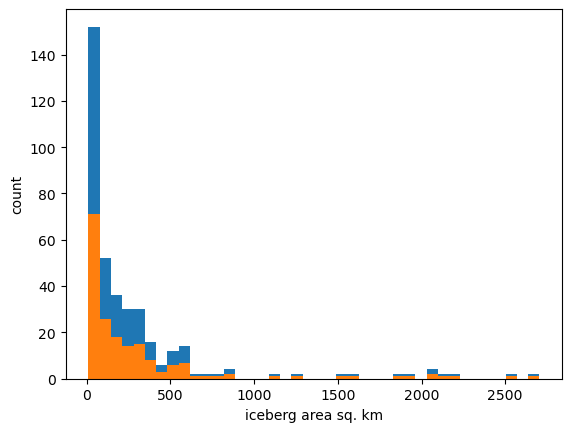

In [8]:
plt.hist(result_df.Max_Size_1 * result_df.Max_Size_2,bins=40);
plt.hist(result_df_dup.Max_Size_1 * result_df_dup.Max_Size_2, bins=40);
plt.xlabel('iceberg area sq. km'); plt.ylabel('count');

In [9]:
result_df_dup['Area'] = (result_df_dup['Max_Size_1'] * 1.852) * (result_df_dup['Max_Size_2'] * 1.852)
result_df_dup.to_csv('largest_named_icebergs_NICBYU.csv', index=False)

In [29]:
def find_largest_area_by_year(result_df):
    if result_df.empty:
        print("DataFrame is empty.")
        return None

    # Convert Date to datetime and extract YEAR
    result_df['Date'] = pd.to_datetime(result_df['Date'], format='%Y%j', errors='coerce')
    result_df['Year'] = result_df['Date'].dt.year

    # Drop rows with no values
    result_df.dropna(subset=['Date'], inplace=True)

    # Group by Year and find the row with the largest value of Area
    largest_areas_by_year = result_df.groupby('Year').apply(lambda x: x.loc[x['Area'].idxmax()])
    return largest_areas_by_year


/tmp/ipykernel_94/1904948248.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  largest_areas_by_year = result_df.groupby('Year').apply(lambda x: x.loc[x['Area'].idxmax()])


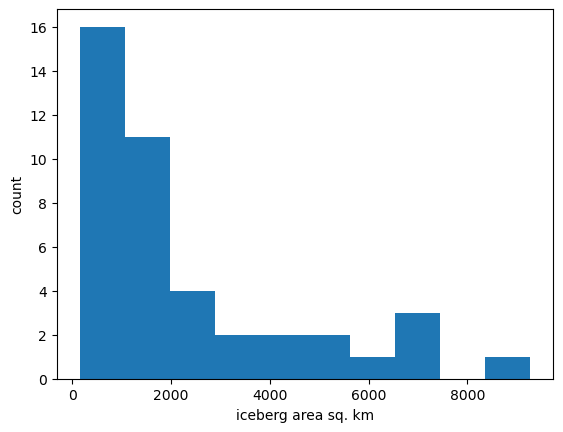

In [30]:
largest_areas_by_year = find_largest_area_by_year(result_df_dup)
#print(largest_areas_by_year)
plt.hist(largest_areas_by_year.Area);
plt.xlabel('iceberg area sq. km'); plt.ylabel('count');

In [31]:
largest_areas_by_year.to_csv('largest_annual_iceberg_NICBYU.csv', index=False)

In [32]:
# cleaned database of largest iceberg area per year from NIC BYU consolidated database
# next step: manually validate data
largest_areas_by_year

,File_Name,Date,Max_Size_1,Max_Size_2,Area,Year
Year,,,,,,
1976.0,d01.csv,1976-02-01,24,17,1399.400832,1976.0
1977.0,d03.csv,1977-12-04,20,15,1028.971200,1977.0
1978.0,a01.csv,1978-10-22,45,25,3858.642000,1978.0
1979.0,c01.csv,1979-09-02,15,40,2057.942400,1979.0
1980.0,a14.csv,1980-12-14,30,20,2057.942400,1980.0
1981.0,a16.csv,1981-11-15,35,15,1800.699600,1981.0
1983.0,a17.csv,1983-04-17,25,23,1972.194800,1983.0
1984.0,b06.csv,1984-02-26,20,20,1371.961600,1984.0
1986.0,a20.csv,1986-01-26,52,52,9274.460416,1986.0
